In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import requests
import os
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import brentq
import scipy.stats as si
from scipy.stats import norm
import matplotlib.patches as patches
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.patches as patches
API_KEY = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
us_holidays = holidays.US(years=2024)
dst_start = pd.to_datetime('2024-03-10')
dst_end = pd.to_datetime('2024-11-03')
fila = 100 # Determina el ancho de la caja en la que buscaremos el máx y el mín.
# no confundir fila que determina la caja del IB con row que determina el núm. de índice cuando la caja es rota.

In [2]:
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 8, 8)

national_holidays = [
    datetime(2024, 1, 1),   # New Year's Day
    datetime(2024, 1, 15),  # Martin Luther King Jr. Day
    datetime(2024, 2, 19),  # Presidents' Day
    datetime(2024, 5, 27),  # Memorial Day
    datetime(2024, 6, 19),  # Juneteenth National Independence Day
    datetime(2024, 7, 4),   # Independence Day
    datetime(2024, 9, 2),   # Labor Day
    datetime(2024, 10, 14), # Columbus Day
    datetime(2024, 11, 11), # Veterans Day
    datetime(2024, 11, 28), # Thanksgiving Day
    datetime(2024, 12, 25)  # Christmas Day
]
working_days = []
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() < 5 and current_date not in national_holidays:
        working_days.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=1)
#working_days

In [3]:
def get_time_based_on_dst(fecha):
    if dst_start <= fecha <= dst_end:
        return pd.to_datetime('13:30:00').time()
    else:
        return pd.to_datetime('14:30:00').time()

def next_working_day(date):
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    next_day = date_obj + timedelta(days=1)
    while next_day.weekday() in (5, 6) or next_day in us_holidays:
        next_day += timedelta(days=1)
    return next_day.strftime('%Y-%m-%d')

def get_stock_price(date, expiration_day):
    url = f"https://api.polygon.io/v2/aggs/ticker/SPY/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    #print(url)  # For debugging purposes
    print(f"Trading Date:    {date}")
    print(f"Expiration Date: {expiration_day}")
    response = requests.get(url)

    if response.status_code == 200:
        try:
            data = response.json()
            if 'results' in data:
                return [(result['t'], result['c']) for result in data['results']]
            else:
                raise ValueError("Response JSON does not contain 'results' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return []

def get_stock_data_for_date(date):
    expiration_day = next_working_day(date)
    option_data = get_stock_price(date, expiration_day)
    df = pd.DataFrame(option_data, columns=['timestamp', 'stock_price'])
    df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    df['time_filter'] = df['fecha'].apply(get_time_based_on_dst)
    df = df[df['fecha'].dt.time >= df['time_filter']]
    df.drop(columns=['time_filter'])
    df['stock_price'] = round(df['stock_price'],2)
    df = df.reset_index(drop=True)
    return df

In [4]:
def check_stock_price_break(df, fila, ib_max, ib_min):
    for i in range(fila + 1, len(df)):
        stock_price_value = df['stock_price'].iloc[i]

        if stock_price_value > ib_max:
            option_type = 'P'
            print(f"El SPY rompe el Máximo del IB en la fila {i} con el valor {stock_price_value}")
            print(f'Tenedencia Alcista-> Vender {option_type}')
            strike_entry = int(stock_price_value) - 3
            print(f'Vendemos el Stike {strike_entry}')
            return i,strike_entry,option_type

        elif stock_price_value < ib_min:
            option_type = 'C'
            print(f"El SPY rompe el Mínimo del IB en la fila {i} con el valor {stock_price_value}")
            strike_entry = int(stock_price_value) + 3
            print(f'Vendemos el Stike {strike_entry}')
            return i,strike_entry,option_type   
    return None

In [5]:
def generate_ticker(df, fila, expiration_day,ib_min, ib_max):
    try:
        # Step 1: Format the expiration date
        expiration_day = expiration_day[2:].replace("-", "")

        # Step 2: Calculate the stock price values
        stock_price_value_ini = ib_min
        stock_price_value = ib_max  
       
        row, strike_entry, option_type = check_stock_price_break(df, fila, ib_max, ib_min)

        # Step 4: Format the strike value
        strike_formatted = f"{strike_entry:05d}" + "000"  # Ensures strike is 8 digits with leading zeros, and appends "0000"

        # Step 5: Construct the final code
        option_code = f"O:SPY{expiration_day}{option_type}{strike_formatted}"
        print(option_code, '-', option_type, strike_entry)
        return option_code, option_type, strike_entry, row

    except Exception as e:
        print(f"An error occurred: {e}. Skipping this iteration.")
        return None, None, None  # Return a tuple of None values in case of an error

In [6]:
def get_option_price(ticker, date, expiration_day, option_type):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    #print(url)
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            # Ensure 'results' key is present in the JSON response
            if 'results' in data:
                results = data['results']
                df_option = pd.DataFrame(results)
                
                # Check what columns are in df_option
                #print(df_option.columns)
                
                # Rename columns if they exist
                if all(col in df_option.columns for col in ['o', 'c', 'l', 'h']):
                    df_option = df_option.rename(columns={
                        't': 'timestamp',
                        'o': 'open',
                        'c': 'close',
                        'l': 'low',
                        'h': 'high'
                    })
                    df_option['option_code'] = ticker
                    df_option['option_type'] = option_type                
                    return df_option[['timestamp', 'option_code', 'option_type', 'close']]
                else:
                    print("Expected columns are not present in the returned data.")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [7]:
def entradas_y_salidas_del_mercado(df, row, option_type,mirror_option_ticker,mirror_option_type):
    df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
    fecha = df['fecha'].iloc[0]
    
    #Calculate mirror values
    mirror_price_entry = round(df_option.iloc[fila]['mirror_close'], 2)
    
    # Calculate required values
    stock_price = round(df.iloc[fila]['stock_price'], 2)
    price_entry = round(df_option.iloc[fila]['close'], 2)
    
    price_entry = price_entry + mirror_price_entry
       
    middle_index = len(df_option) // 2
    price_overnight = round(df_option.iloc[middle_index-30]['close'], 2)
    mirror_price_overnight = round(df_option.iloc[middle_index-30]['mirror_close'], 2)
    price_overnight = mirror_price_overnight + price_overnight
    
    end_index = len(df_option) - 5
    price_end = round(df_option.iloc[end_index]['close'], 2)
    mirror_price_end = round(df_option.iloc[end_index]['mirror_close'], 2)
    price_end = price_end + mirror_price_end
    
    profit_overnight = abs(price_overnight - price_entry)
    profit_end = price_entry-price_end
    
    if profit_end > 0:
        df_option['win_lose'] = 'win'
        win_lose = 'win'
    else:
        df_option['win_lose'] = 'lose'
        win_lose = 'lose' 
        
    df_option['cum_return'] = 0
    
    valor_par_put_call = df_option.loc[fila:, 'close'] + df_option.loc[fila:, 'mirror_close']
    df_option.loc[row:, 'cum_return'] = price_entry - valor_par_put_call
        
    mae = df_option['cum_return'].max()
    mae_perc = round(mae/price_entry*100,0)
    return_ = round(profit_end/price_entry*100,0)

    # Create a dictionary with the summary data
    summary_data = {
        'fecha': fecha,
        'option': option_code,
        'type': option_type,
        'strike':strike_entry,
        'stock_entry': stock_price,
        'price_entry': price_entry,
        'price_overn': price_overnight,
        'price_end': price_end,
        'profit_overn': profit_overnight,
        'profit_end': profit_end,
        'return_%': return_,
        'win_lose': win_lose,
        'mae': mae,
        'mae_%': mae_perc
    }
    return summary_data

In [8]:
def plot_option_chart(df_option, fila, strike_entry, option_type, option_code, ib_min, ib_max, row):
    ovenight_index = int(len(df_option) / 2) - 40
    end_index = len(df_option) - 2
    rectangle = fila - 2
    df_option['fecha'] = df_option['fecha'].astype(str)
    fig, (ax1, ax3) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.04})
    ax2 = ax1.twinx()
    ax1.plot(df_option['fecha'], df_option['close'], color='green', label='Option', linewidth=1.0)
    ax1.plot(df_option['fecha'], df_option['mirror_close'], color='red', label='Option', linewidth=1.0)
    
    ax2.plot(df_option['fecha'], df_option['stock_price'], color='blue', alpha=1.0, linewidth=0.8)
    ax1.set_ylabel('Prima', color='green')
    ax2.set_ylabel('Stock Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='green')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax1.yaxis.grid(True, alpha=0.6)
    ax1.xaxis.grid(False)
    ax1.tick_params(axis='x', which='both', length=0, labelbottom=False)
    ax1.axvline(x=row, color='grey', alpha=0.56, linestyle='-', linewidth=0.7)
    ax1.axvline(x=ovenight_index, color='grey', alpha=0.5, linestyle='-', linewidth=0.7)
    ax2.axhline(y=strike_entry, color='green', alpha=0.5, linestyle='--')
    ax2.axhline(y=mirror_strike, color='red', alpha=0.5, linestyle='--')
    
    ax1.plot(df_option['fecha'][row], df_option['close'][row], 'ko', markersize=9)
    ax1.plot(df_option['fecha'][row], df_option['mirror_close'][row], 'ko', markersize=9)
    
    
    ax1.plot(df_option['fecha'][ovenight_index], df_option['close'][ovenight_index], 'ro', markersize=9)
    ax1.plot(df_option['fecha'][ovenight_index], df_option['mirror_close'][ovenight_index], 'ro', markersize=9)
    
    ax1.plot(df_option['fecha'][end_index], df_option['close'][end_index], 'ro', markersize=9)
    ax1.plot(df_option['fecha'][end_index], df_option['mirror_close'][end_index], 'ro', markersize=9)
    
    ax1.set_title(f'Opción primaria {option_code} - {option_type}{strike_entry}-{mirror_option_type}{mirror_strike}')
    ax3.fill_between(df_option['fecha'], df_option['cum_return'], where=(df_option['cum_return'] >= 0),
                     color='green', alpha=0.5, label='Beneficio')
    ax3.fill_between(df_option['fecha'], df_option['cum_return'], where=(df_option['cum_return'] < 0),
                     color='red', alpha=0.5, label='Pérdida')
    ax3.set_ylabel('Beneficio Acumulado')
    ax3.tick_params(axis='y')
    ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment('right')
    ax3.yaxis.grid(True, alpha=0.6)
    ax3.xaxis.grid(False)
    ax3.legend(loc='upper left')
    
    width = df_option.index[rectangle] - df_option.index[0]
    rect = patches.Rectangle(
        (df_option.index[0], ib_min),
        width=width,
        height=(ib_max - ib_min),
        linewidth=2,
        edgecolor='orange',
        facecolor='orange',
        alpha=0.3
)
    ax2.add_patch(rect)
    
    output_dir = 'chart_output_strangle'
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'sell_the_swan_strangle_{timestamp}.png'
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path)
    plt.show()

In [9]:
def find_min_max_stock_price(df):
    # Seleccionamos las filas 
    subset = df.iloc[0:fila]
    ib_min = subset['stock_price'].min()
    ib_max = subset['stock_price'].max()
    return ib_min, ib_max

In [10]:
def generate_mirror_option_ticker(option_code, option_type, option_strike):
    # Step 1: Extract components from the option_code
    prefix = option_code[:-9]  # Everything before the strike and option type
    suffix = option_code[-8:]  # The last eight characters, including the original strike price and other details
    
    mirror =6
    
    # Extract the original strike and option type from the suffix
    original_strike_str = suffix[3:8]  # The 5-digit strike price part (e.g., '00469')
    original_option_type = suffix[0]   # The option type (P or C)
    
    # Step 2: Modify the strike price based on the option_type
    if option_type == 'P':
        mirror_option_type = 'C'  # Change 'P' to 'C'
        mirror_strike = option_strike + mirror  # Increase the strike price by 6
    elif option_type == 'C':
        mirror_option_type = 'P'  # Change 'C' to 'P'
        mirror_strike = option_strike - mirror  # Decrease the strike price by 6
    else:
        return "Invalid option type", None, None

    # Ensure the new strike is positive and format it to 5 digits with leading zeros
    if mirror_strike < 0:
        return "Invalid strike price", None, None

    mirror_strike_str = str(mirror_strike).zfill(5)
    
    # Step 4: Construct the new option ticker
    # Reconstruct the ticker with the correct prefix, new type, new strike, and suffix
    new_suffix = f"{mirror_strike_str}{suffix[-3:]}"  # Include the last 3 characters of the original suffix
    mirror_option_ticker = f"{prefix}{mirror_option_type}{new_suffix}"
    return mirror_option_ticker, mirror_option_type, mirror_strike


In [11]:
  '''
dates = [
 '2024-01-03',
 '2024-04-15',
 '2024-08-05'
]

'''
dates = ['2024-01-02',
 '2024-01-03',
 '2024-01-04',
 '2024-01-05',
 '2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-22',
 '2024-01-23',
 '2024-01-24',
 '2024-01-25',
 '2024-01-26',
 '2024-01-29',
 '2024-01-30',
 '2024-01-31',
 '2024-02-01',
 '2024-02-02',
 '2024-02-05',
 '2024-02-06',
 '2024-02-07',
 '2024-02-08',
 '2024-02-09',
 '2024-02-12',
 '2024-02-13',
 '2024-02-14',
 '2024-02-15',
 '2024-02-16',
 '2024-02-20',
 '2024-02-21',
 '2024-02-22',
 '2024-02-23',
 '2024-02-26',
 '2024-02-27',
 '2024-02-28',
 '2024-02-29',
 '2024-03-01',
 '2024-03-04',
 '2024-03-05',
 '2024-03-06',
 '2024-03-07',
 '2024-03-08',
 '2024-03-11',
 '2024-03-12',
 '2024-03-13',
 '2024-03-14',
 '2024-03-15',
 '2024-03-18',
 '2024-03-19',
 '2024-03-20',
 '2024-03-21',
 '2024-03-22',
 '2024-03-25',
 '2024-03-26',
 '2024-03-27',
 '2024-03-28',
 '2024-03-29',
 '2024-04-01',
 '2024-04-02',
 '2024-04-03',
 '2024-04-04',
 '2024-04-05',
 '2024-04-08',
 '2024-04-09',
 '2024-04-10',
 '2024-04-11',
 '2024-04-12',
 '2024-04-15',
 '2024-04-16',
 '2024-04-17',
 '2024-04-18',
 '2024-04-19',
 '2024-04-22',
 '2024-04-23',
 '2024-04-24',
 '2024-04-25',
 '2024-04-26',
 '2024-04-29',
 '2024-04-30',
 '2024-05-01',
 '2024-05-02',
 '2024-05-03',
 '2024-05-06',
 '2024-05-07',
 '2024-05-08',
 '2024-05-09',
 '2024-05-10',
 '2024-05-13',
 '2024-05-14',
 '2024-05-15',
 '2024-05-16',
 '2024-05-17',
 '2024-05-20',
 '2024-05-21',
 '2024-05-22',
 '2024-05-23',
 '2024-05-24',
 '2024-05-28',
 '2024-05-29',
 '2024-05-30',
 '2024-05-31',
 '2024-06-03',
 '2024-06-04',
 '2024-06-05',
 '2024-06-06',
 '2024-06-07',
 '2024-06-10',
 '2024-06-11',
 '2024-06-12',
 '2024-06-13',
 '2024-06-14',
 '2024-06-17',
 '2024-06-18',
 '2024-06-20',
 '2024-06-21',
 '2024-06-24',
 '2024-06-25',
 '2024-06-26',
 '2024-06-27',
 '2024-06-28',
 '2024-07-01',
 '2024-07-02',
 '2024-07-03',
 '2024-07-05',
 '2024-07-08',
 '2024-07-09',
 '2024-07-10',
 '2024-07-11',
 '2024-07-12',
 '2024-07-15',
 '2024-07-16',
 '2024-07-17',
 '2024-07-18',
 '2024-07-19',
 '2024-07-22',
 '2024-07-23',
 '2024-07-24',
 '2024-07-25',
 '2024-07-26',
 '2024-07-29',
 '2024-07-30',
 '2024-07-31',
 '2024-08-01',
 '2024-08-02',
 '2024-08-05',
 '2024-08-06',
 '2024-08-07',
 '2024-08-08']


"\ndates = ['2024-01-02',\n '2024-01-03',\n '2024-01-04',\n '2024-01-05',\n '2024-01-08',\n '2024-01-09',\n '2024-01-10',\n '2024-01-11',\n '2024-01-12',\n '2024-01-16',\n '2024-01-17',\n '2024-01-18',\n '2024-01-19',\n '2024-01-22',\n '2024-01-23',\n '2024-01-24',\n '2024-01-25',\n '2024-01-26',\n '2024-01-29',\n '2024-01-30',\n '2024-01-31',\n '2024-02-01',\n '2024-02-02',\n '2024-02-05',\n '2024-02-06',\n '2024-02-07',\n '2024-02-08',\n '2024-02-09',\n '2024-02-12',\n '2024-02-13',\n '2024-02-14',\n '2024-02-15',\n '2024-02-16',\n '2024-02-20',\n '2024-02-21',\n '2024-02-22',\n '2024-02-23',\n '2024-02-26',\n '2024-02-27',\n '2024-02-28',\n '2024-02-29',\n '2024-03-01',\n '2024-03-04',\n '2024-03-05',\n '2024-03-06',\n '2024-03-07',\n '2024-03-08',\n '2024-03-11',\n '2024-03-12',\n '2024-03-13',\n '2024-03-14',\n '2024-03-15',\n '2024-03-18',\n '2024-03-19',\n '2024-03-20',\n '2024-03-21',\n '2024-03-22',\n '2024-03-25',\n '2024-03-26',\n '2024-03-27',\n '2024-03-28',\n '2024-03-29'

Trading Date:    2024-01-03
Expiration Date: 2024-01-04
Valor mínimo IB:     468.78
Valor máximo IB:     470.82
El SPY rompe el Máximo del IB en la fila 297 con el valor 470.91
Tenedencia Alcista-> Vender P
Vendemos el Stike 467
O:SPY240104P00467000 - P 467
Entramos en la fila: 297
original option code O:SPY240104P00467000, original strike 467, option type P
mirror option code O:SPY240104C00473000, mirror strike 473, mirror type C


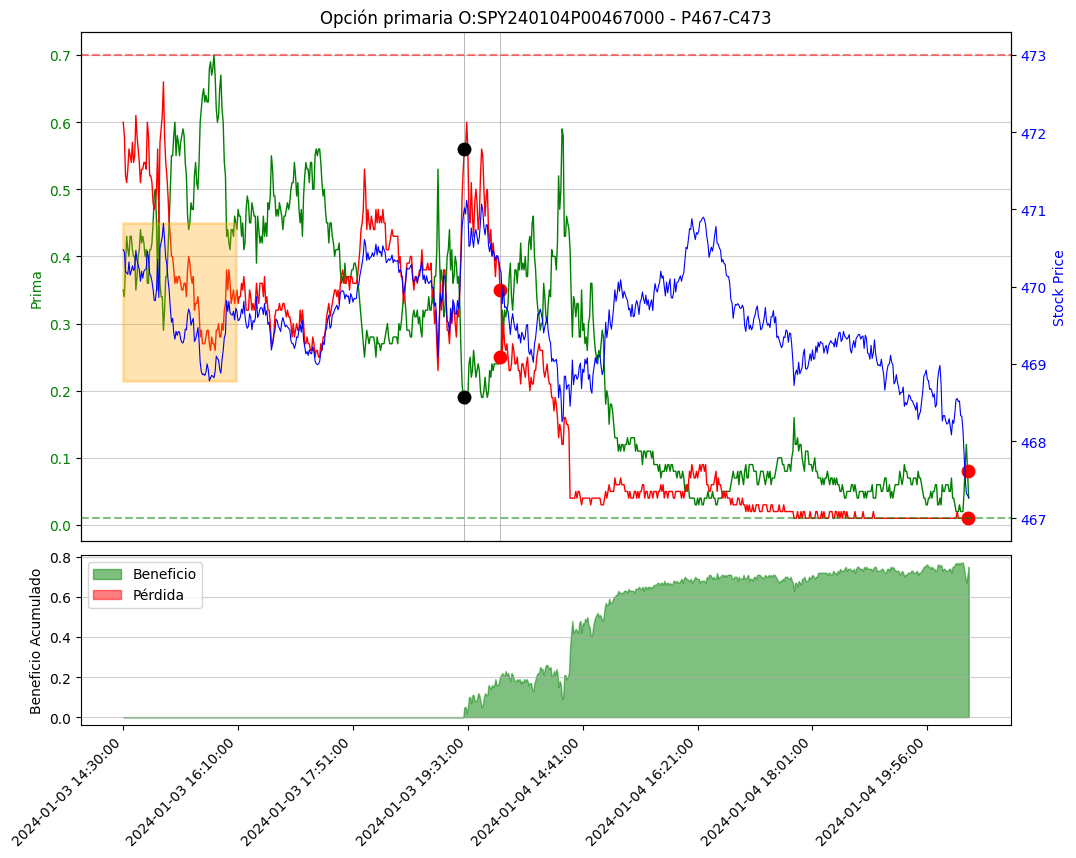

Trading Date:    2024-04-15
Expiration Date: 2024-04-16
Valor mínimo IB:     510.98
Valor máximo IB:     515.18
El SPY rompe el Mínimo del IB en la fila 112 con el valor 510.88
Vendemos el Stike 513
O:SPY240416C00513000 - C 513
Entramos en la fila: 112
original option code O:SPY240416C00513000, original strike 513, option type C
mirror option code O:SPY240416P00507000, mirror strike 507, mirror type P


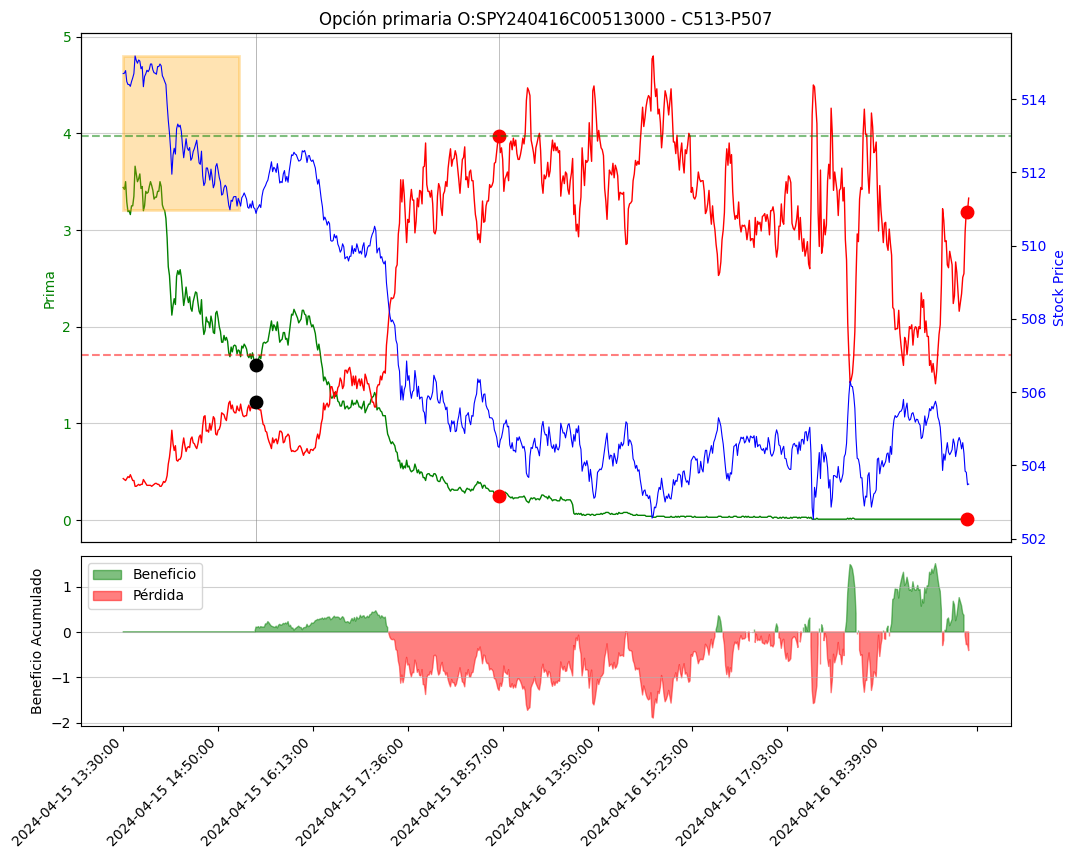

Trading Date:    2024-08-05
Expiration Date: 2024-08-06
Valor mínimo IB:     510.87
Valor máximo IB:     520.78
El SPY rompe el Máximo del IB en la fila 114 con el valor 520.87
Tenedencia Alcista-> Vender P
Vendemos el Stike 517
O:SPY240806P00517000 - P 517
Entramos en la fila: 114
original option code O:SPY240806P00517000, original strike 517, option type P
mirror option code O:SPY240806C00523000, mirror strike 523, mirror type C


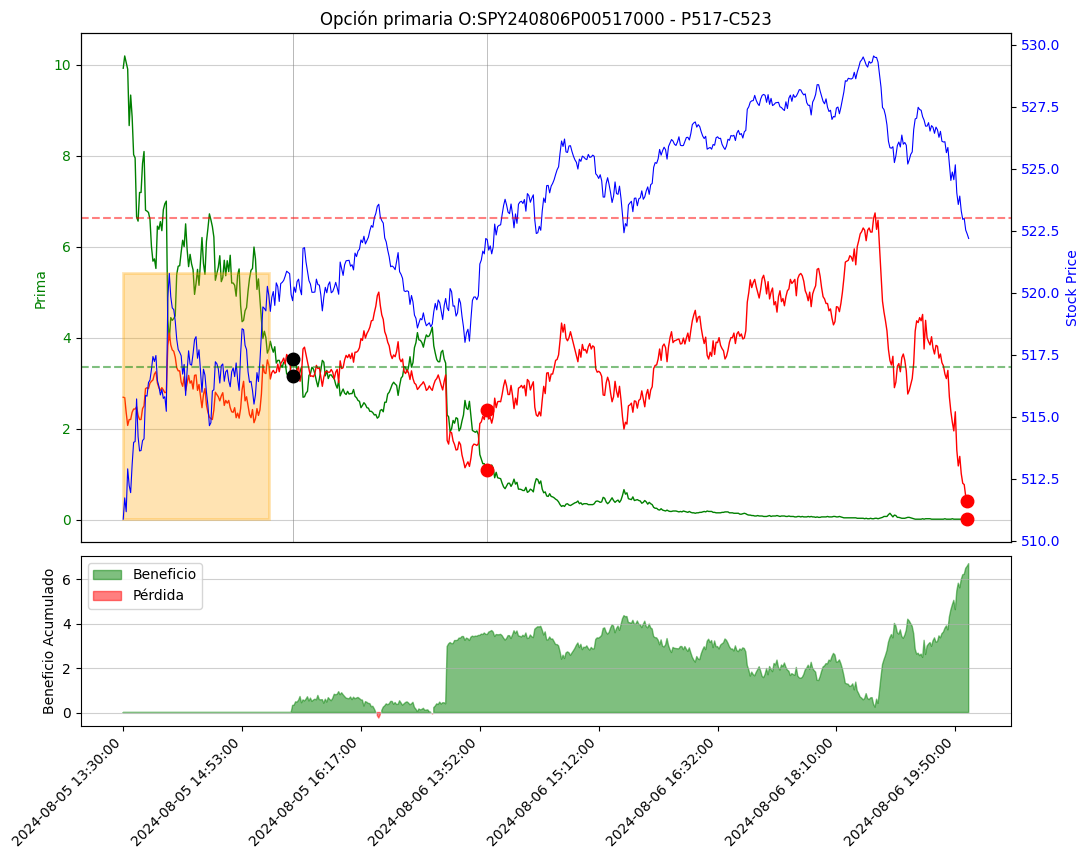

In [12]:
final_summary = pd.DataFrame()
for date in dates:
    df = get_stock_data_for_date(date)  # Create the dataframe with the stock SPY data
    expiration_day = next_working_day(date)  # Get the expiration day of the option
    ib_min, ib_max = find_min_max_stock_price(df)  # Find the minimum and maximum of the IB box
    print(f"Valor mínimo IB:     {ib_min}\nValor máximo IB:     {ib_max}")
    
    # Generate the option ticker and get the option type, strike entry, and entry row
    option_code, option_type, strike_entry, row = generate_ticker(df, fila, expiration_day, ib_min, ib_max)
    print(f'Entramos en la fila: {row}')
    print(f'original option code {option_code}, original strike {strike_entry}, option type {option_type}')
    
    # Get the option price data
    df_option = get_option_price(option_code, date, expiration_day, option_type)
  
    # Ensure the function name is not overwritten
    mirror_option_ticker, mirror_option_type, mirror_strike = generate_mirror_option_ticker(option_code, option_type, strike_entry)
    print(f'mirror option code {mirror_option_ticker}, mirror strike {mirror_strike}, mirror type {mirror_option_type}')
    
    df_mirror = get_option_price(mirror_option_ticker, date, expiration_day, mirror_option_type)
    
    # Check if df_option is None or empty and handle accordingly
    if df_option is None or df_option.empty:
        print(f"Warning: No data returned for {option_code} on {date} with expiration {expiration_day}. Skipping this iteration.")
        continue  # Skip this iteration since no valid data is available for df_option
    
    try:
        # Perform the merge operation with the 'left' join to retain all rows from df
        df_option = pd.merge(df, df_option, on='timestamp', how='left')
        
        # Forward fill any missing data in the merged dataframe
        df_option.ffill(inplace=True)
        
        df_mirror.rename(columns={'close': 'mirror_close'}, inplace=True)
        df_mirror.ffill(inplace=True)
        df_mirror = df_mirror[['timestamp', 'mirror_close']]
        df_option = pd.merge(df_option, df_mirror, on='timestamp')
        
        # Process the market entries and exits based on the merged data
        summary = entradas_y_salidas_del_mercado(df_option, row, option_type,mirror_option_ticker,mirror_option_type)
        
        # Append the summary to the final_summary dataframe
        final_summary = final_summary.append(summary, ignore_index=True)
        
        # Plot the option chart
        plot_option_chart(df_option, fila, strike_entry, option_type, option_code, ib_min, ib_max, row)
    
    except Exception as e:
        print(f"An error occurred during merging or processing: {e}. Skipping this iteration.")
    
    # Pause for 10 seconds to avoid hitting API limits
    time.sleep(10)

In [15]:
final_summary

,fecha,option,type,strike,stock_entry,price_entry,price_overn,price_end,profit_overn,profit_end,return_%,win_lose,mae,mae_%
0,2024-01-03 14:30:00,O:SPY240104P00467000,P,467,469.56,0.80,0.58,0.06,0.22,0.74,92.0,win,0.77,96.0
1,2024-04-15 13:30:00,O:SPY240416C00513000,C,513,511.31,2.93,4.15,2.56,1.22,0.37,13.0,win,1.51,52.0
2,2024-08-05 13:30:00,O:SPY240806P00517000,P,517,519.82,7.01,3.55,0.81,3.46,6.20,88.0,win,6.70,96.0


In [16]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'summary_stradle_{timestamp}.csv'
final_summary.to_csv(filename, index=False)

SUMARIO

In [17]:
print("SUMMARIO:\n")
total_wins = final_summary[final_summary['win_lose'] == 'win'].shape[0]
total_losses = final_summary[final_summary['win_lose'] == 'lose'].shape[0]
total_trades = final_summary.shape[0]
percentage_wins = (total_wins / total_trades) * 100
percentage_losses = (total_losses / total_trades) * 100
average_win = final_summary[final_summary['win_lose'] == 'win']['profit_end'].mean()
average_loss = final_summary[final_summary['win_lose'] == 'lose']['profit_end'].mean()
expectancy = ((percentage_wins * average_win) - (percentage_losses * average_loss))/100
print(f"Percentage of Wins:   {percentage_wins:.2f}%")
print(f"Percentage of Losses: {percentage_losses:.2f}%")
print(f"Average Win:            {average_win:.2f}")
print(f"Average Loss:          {average_loss:.2f}")
print(f"Expectancy:             {expectancy:.2f}\n")
profit_overn_avg = round(final_summary['profit_overn'].mean(), 2)
profit_overn_max = round(final_summary['profit_overn'].max(), 2)
profit_overn_min = round(final_summary['profit_overn'].min(), 2)
profit_overn_sum = round(final_summary['profit_overn'].sum(), 2)
profit_end_avg = round(final_summary['profit_end'].mean(), 2)
profit_end_max = round(final_summary['profit_end'].max(), 2)
profit_end_min = round(final_summary['profit_end'].min(), 2)
profit_end_sum = round(final_summary['profit_end'].sum(), 2)
return_percent_avg = round(final_summary['return_%'].mean(), 2)
return_percent_max = round(final_summary['return_%'].max(), 2)
return_percent_min = round(final_summary['return_%'].min(), 2)
return_percent_sum = round(final_summary['return_%'].sum(), 2)
mae_avg = round(final_summary['mae'].mean(), 2)
mae_max = round(final_summary['mae'].max(), 2)
mae_min = round(final_summary['mae'].min(), 2)
mae_sum = round(final_summary['mae'].sum(), 2)

print("Profit Overnight:")
print(f"Average: {profit_overn_avg}")
print(f"Min: {profit_overn_min}")
print(f"Max: {profit_overn_max}")
print(f"Total Sum: {profit_overn_sum}\n")
print("Profit End:")
print(f"Average: {profit_end_avg}")
print(f"Min: {profit_end_min}")
print(f"Max: {profit_end_max}")
print(f"Total Sum: {profit_end_sum}\n")
print("Return %:")
print(f"Average: {return_percent_avg}")
print(f"Min: {return_percent_min}")
print(f"Max: {return_percent_max}")
print(f"Min: {return_percent_min}")
print(f"Total Sum: {return_percent_sum}\n")
print("MAE:")
print(f"Average: {mae_avg}")
print(f"Max: {mae_max}")
print(f"Min: {mae_min}")
print(f"Total Sum: {mae_sum}")

SUMMARIO:

Percentage of Wins:   100.00%
Percentage of Losses: 0.00%
Average Win:            2.44
Average Loss:          nan
Expectancy:             nan

Profit Overnight:
Average: 1.63
Min: 0.22
Max: 3.46
Total Sum: 4.9

Profit End:
Average: 2.44
Min: 0.37
Max: 6.2
Total Sum: 7.31

Return %:
Average: 64.33
Min: 13.0
Max: 92.0
Min: 13.0
Total Sum: 193.0

MAE:
Average: 2.99
Max: 6.7
Min: 0.77
Total Sum: 8.98


In [18]:
total_wins = final_summary[final_summary['win_lose'] == 'win'].shape[0]
total_losses = final_summary[final_summary['win_lose'] == 'lose'].shape[0]
total_trades = final_summary.shape[0]
percentage_wins = (total_wins / total_trades) * 100
percentage_losses = (total_losses / total_trades) * 100
average_win = final_summary[final_summary['win_lose'] == 'win']['profit_end'].mean()
average_loss = final_summary[final_summary['win_lose'] == 'lose']['profit_end'].mean()
expectancy = ((percentage_wins * average_win) - (percentage_losses * average_loss))/100
print(f"Percentage of Wins:   {percentage_wins:.2f}%")
print(f"Percentage of Losses: {percentage_losses:.2f}%")
print(f"Average Win:            {average_win:.2f}")
print(f"Average Loss:          {average_loss:.2f}")
print(f"Expectancy:             {expectancy:.2f}")

Percentage of Wins:   100.00%
Percentage of Losses: 0.00%
Average Win:            2.44
Average Loss:          nan
Expectancy:             nan


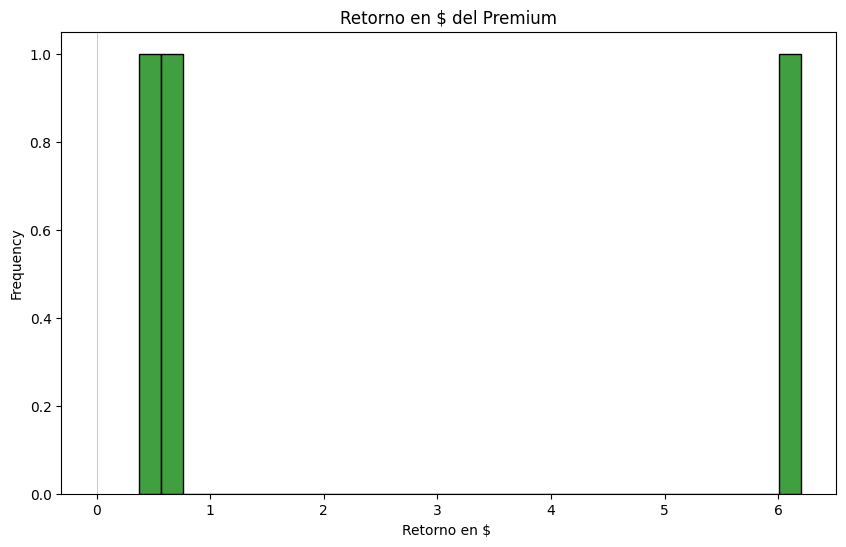

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(final_summary['profit_end'], color='green',bins=30)
plt.axvline(x=0, color='grey', alpha=0.6, linewidth=0.5)
plt.title('Retorno en $ del Premium')
plt.xlabel('Retorno en $ ')
plt.ylabel('Frequency')
plt.show()

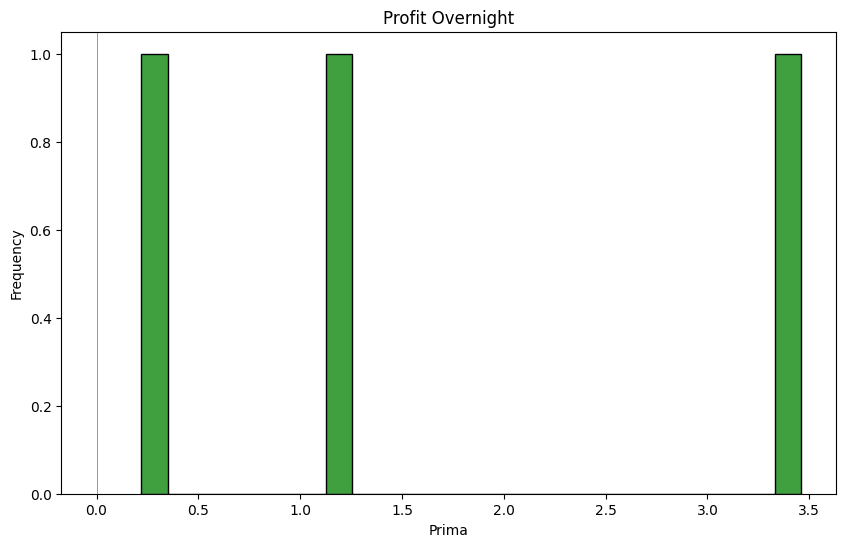

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(final_summary['profit_overn'],color='green', bins=25)
plt.axvline(x=0, color='grey', alpha=0.8, linewidth=0.7)
plt.title('Profit Overnight')
plt.xlabel('Prima')
plt.ylabel('Frequency')
plt.show()

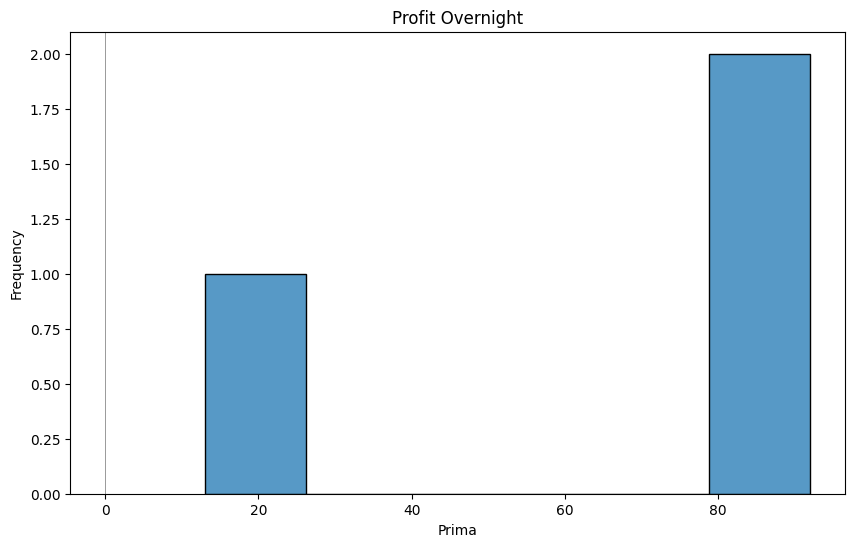

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(final_summary['return_%'], bins=6)
plt.axvline(x=0, color='grey', alpha=0.8, linewidth=0.7)
plt.title('Profit Overnight')
plt.xlabel('Prima')
plt.ylabel('Frequency')
plt.show()

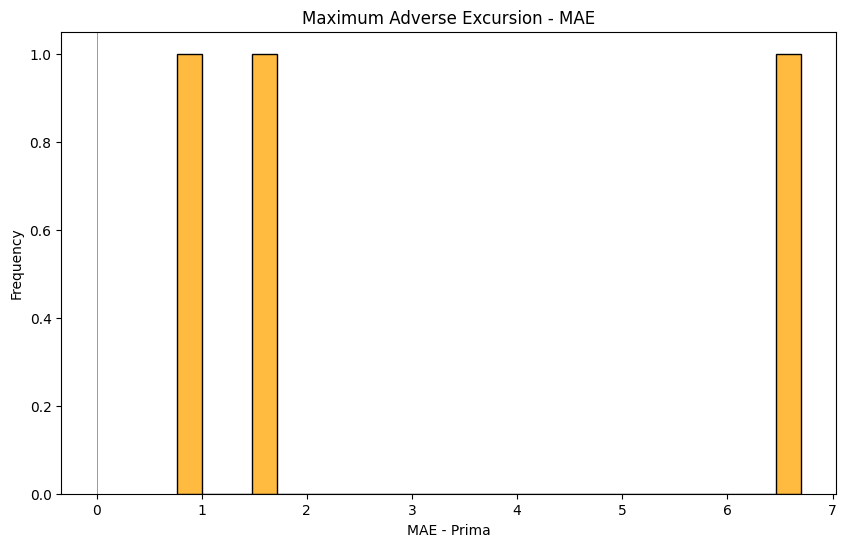

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(final_summary['mae'], color ='orange',bins=25)
plt.axvline(x=0, color='grey', alpha=0.8, linewidth=0.7)
plt.title('Maximum Adverse Excursion - MAE')
plt.xlabel('MAE - Prima')
plt.ylabel('Frequency')
plt.show()

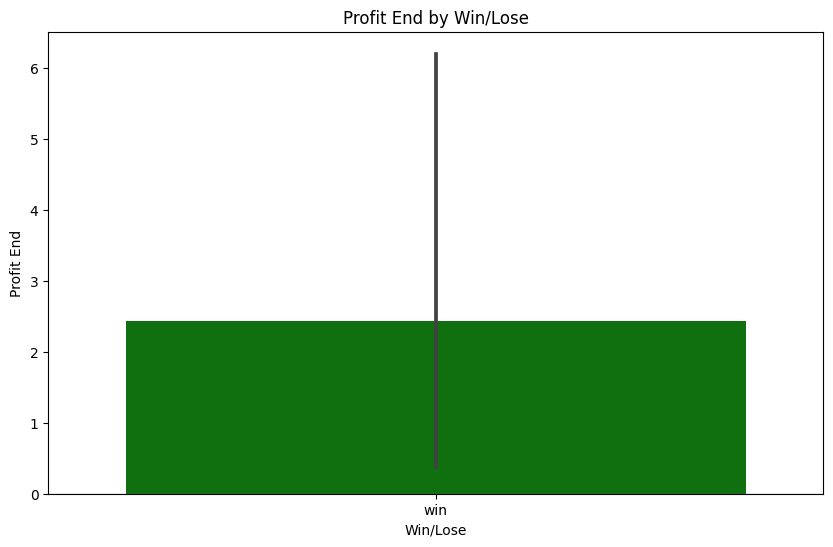

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=final_summary['win_lose'], 
    y=final_summary['profit_end'],
    palette=(final_summary['profit_end'] > 0).map({True: 'green', False: 'red'})
)
plt.axhline(y=0, color='grey', alpha=0.9, linewidth=0.9)  # Horizontal line at 0
plt.title('Profit End by Win/Lose')
plt.xlabel('Win/Lose')
plt.ylabel('Profit End')
plt.show()

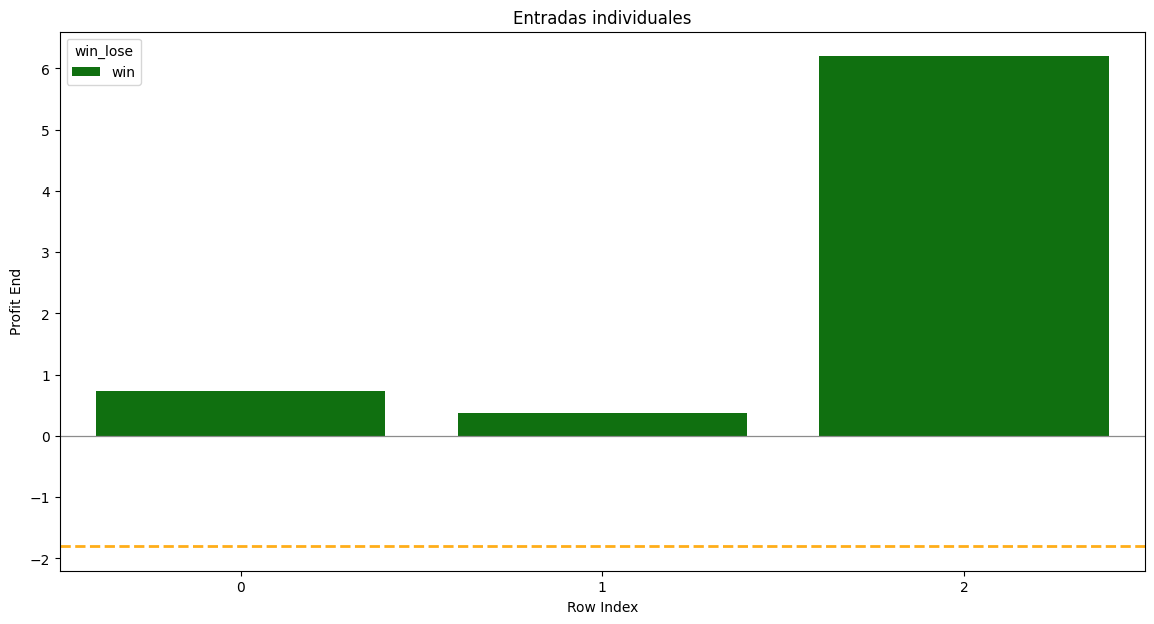

In [24]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x=final_summary.index,  # Use the index for the x-axis to represent all rows
    y=final_summary['profit_end'],
    hue=final_summary['win_lose'],  # Color based on win/lose
    palette={'win': 'green', 'lose': 'red'}
)
plt.axhline(y=0, color='grey', alpha=0.9, linewidth=0.9)  # Horizontal line at 0
plt.axhline(y=-1.8, color='orange', alpha=0.9, linestyle='--', linewidth=2)
plt.title('Entradas individuales')
plt.xlabel('Row Index')
plt.ylabel('Profit End')
plt.show()

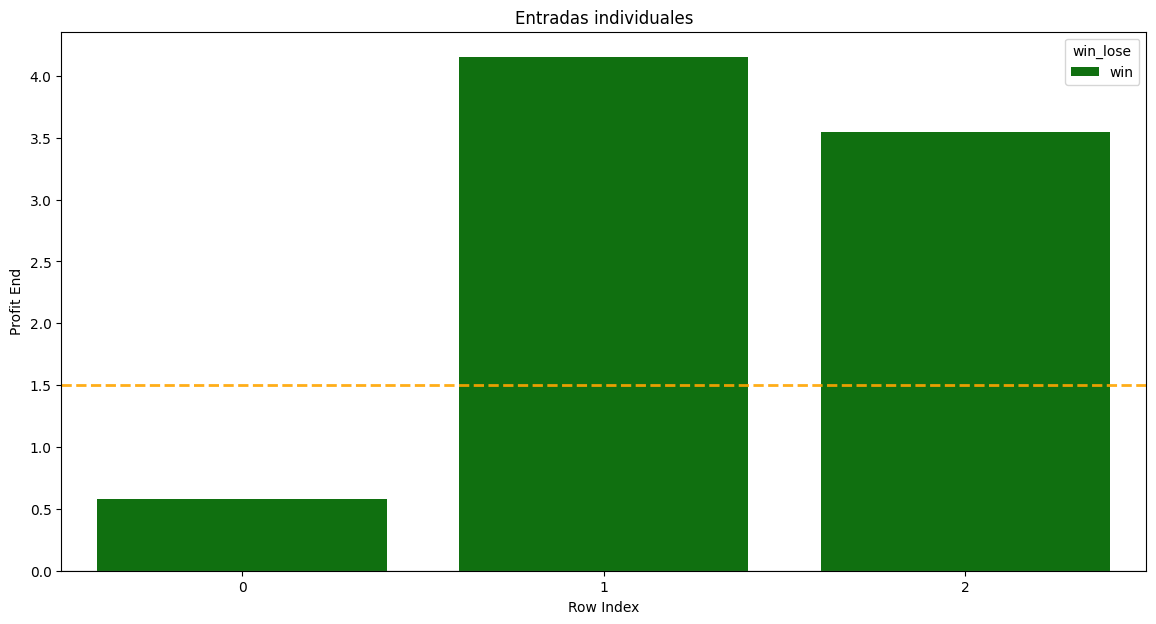

In [25]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x=final_summary.index,  # Use the index for the x-axis to represent all rows
    y=final_summary['price_overn'],
    hue=final_summary['win_lose'],  # Color based on win/lose
    palette={'win': 'green', 'lose': 'red'}
)
plt.axhline(y=0, color='grey', alpha=0.9, linewidth=0.9)  # Horizontal line at 0
plt.axhline(y=1.5, color='orange', alpha=0.9, linestyle='--', linewidth=2)
plt.title('Entradas individuales')
plt.xlabel('Row Index')
plt.ylabel('Profit End')
plt.show()

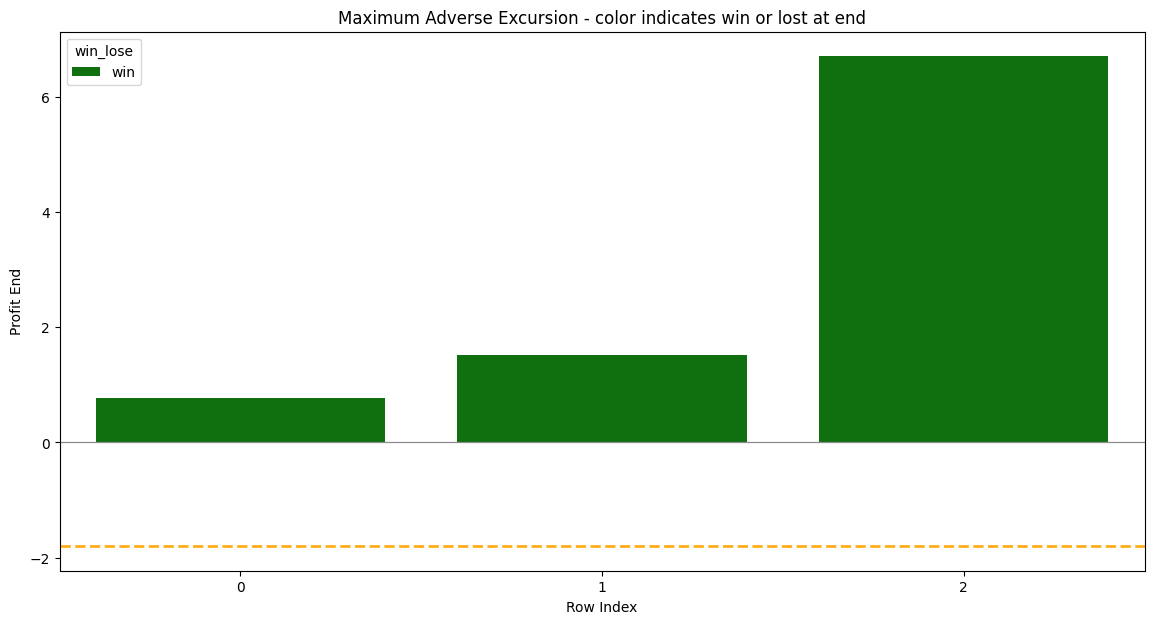

In [26]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x=final_summary.index,  # Use the index for the x-axis to represent all rows
    y=final_summary['mae'],
    hue=final_summary['win_lose'],  # Color based on win/lose
    palette={'win': 'green', 'lose': 'red'}
)
plt.axhline(y=0, color='grey', alpha=0.9, linewidth=0.9)  # Horizontal line at 0
plt.axhline(y=-1.8, color='orange', alpha=0.9, linestyle='--', linewidth=2)
plt.title('Maximum Adverse Excursion - color indicates win or lost at end')
plt.xlabel('Row Index')
plt.ylabel('Profit End')
plt.show()

In [27]:
filtered_summary = final_summary[final_summary['profit_end'] <= 0]
contador = len(filtered_summary)
print(f'La cantidad de entradas perdedoras es {contador}')
filtered_summary

La cantidad de entradas perdedoras es 0


,fecha,option,type,strike,stock_entry,price_entry,price_overn,price_end,profit_overn,profit_end,return_%,win_lose,mae,mae_%


In [28]:
DFGSDGFSDG

NameError: name 'DFGSDGFSDG' is not defined

In [ ]:
final_summary = pd.DataFrame()

for date in dates:
    df = get_stock_data_for_date(date)  # Create the dataframe with the stock SPY data
    expiration_day = next_working_day(date)  # Get the expiration day of the option
    ib_min, ib_max = find_min_max_stock_price(df)  # Find the minimum and maximum of the IB box
    print(f"Valor mínimo IB:     {ib_min}\nValor máximo IB:     {ib_max}")
    
    # Generate the option ticker and get the option type, strike entry, and entry row
    option_code, option_type, strike_entry, row = generate_ticker(df, fila, expiration_day, ib_min, ib_max)
    print(f'Entramos en la fila: {row}')
    
    # Get the option price data
    df_option = get_option_price(option_code, date, expiration_day, option_type)
    
    # Check if df_option is None or empty and handle accordingly
    if df_option is None or df_option.empty:
        print(f"Warning: No data returned for {option_code} on {date} with expiration {expiration_day}")
        df_option = pd.DataFrame(columns=['timestamp'])  # Create an empty DataFrame with a timestamp column to prevent errors
    
    # Perform the merge operation with the 'left' join to retain all rows from df
    df_option = pd.merge(df, df_option, on='timestamp', how='left')
    
    # Forward fill any missing data in the merged dataframe
    df_option.ffill(inplace=True)
    
    # Process the market entries and exits based on the merged data
    summary = entradas_y_salidas_del_mercado(df_option, row, option_type)
    
    # Append the summary to the final_summary dataframe
    final_summary = final_summary.append(summary, ignore_index=True)
    
    # Plot the option chart
    plot_option_chart(df_option, fila, strike_entry, option_type, option_code, ib_min, ib_max, row)
    
    # Pause for 35 seconds to avoid hitting API limits
    time.sleep(35)

In [ ]:
final_summary = pd.DataFrame()

for date in dates:
    df = get_stock_data_for_date(date)  # Create the dataframe with the stock SPY data
    expiration_day = next_working_day(date)  # Get the expiration day of the option
    ib_min, ib_max = find_min_max_stock_price(df)  # Find the minimum and maximum of the IB box
    print(f"Valor mínimo IB:     {ib_min}\nValor máximo IB:     {ib_max}")
    
    # Generate the option ticker and get the option type, strike entry, and entry row
    option_code, option_type, strike_entry, row = generate_ticker(df, fila, expiration_day, ib_min, ib_max)
    print(f'Entramos en la fila: {row}')
    print(f'original option code {option_code}, original strike {strike_entry}, option type {option_type}')
    # Get the option price data
    df_option = get_option_price(option_code, date, expiration_day, option_type)
    print(f'ddddddddd {strike_entry}')
    
    mirror_option_ticker, mirror_option_type, mirror_strike = mirror_option_ticker(option_code, option_type, strike_entry)
    print(f'mirror option code {mirror_option_ticker}, mirror strike {mirror_strike}, mirror type {mirror_option_type}')
    
    # Check if df_option is None or empty and handle accordingly
    if df_option is None or df_option.empty:
        print(f"Warning: No data returned for {option_code} on {date} with expiration {expiration_day}. Skipping this iteration.")
        continue  # Skip this iteration since no valid data is available for df_option
    
    try:
        # Perform the merge operation with the 'left' join to retain all rows from df
        df_option = pd.merge(df, df_option, on='timestamp', how='left')
        
        # Forward fill any missing data in the merged dataframe
        df_option.ffill(inplace=True)
        
        # Process the market entries and exits based on the merged data
        summary = entradas_y_salidas_del_mercado(df_option, row, option_type)
        
        # Append the summary to the final_summary dataframe
        final_summary = final_summary.append(summary, ignore_index=True)
        
        # Plot the option chart
        plot_option_chart(df_option, fila, strike_entry, option_type, option_code, ib_min, ib_max, row)
    
    except Exception as e:
        print(f"An error occurred during merging or processing: {e}. Skipping this iteration.")
    
    # Pause for 35 seconds to avoid hitting API limits
    time.sleep(10)

In [ ]:
def mirror_option_ticker(option_code, option_type, option_strike):
    # Step 1: Extract components from the option_code
    prefix = option_code[:-8]  # Everything before the strike and option type
    suffix = option_code[-3:]  # The last three characters after the strike (e.g., '000')
    
    # Step 2: Modify the strike price based on the option_type
    if option_type == 'P':
        mirror_option_type = 'C'  # Change 'P' to 'C'
        mirror_strike = option_strike + 6  # Increase the strike price by 6
    elif option_type == 'C':
        mirror_option_type = 'P'  # Change 'C' to 'P'
        mirror_strike = option_strike - 6  # Decrease the strike price by 6
    else:
        return "Invalid option type", None, None

    # Ensure the new strike is positive and format it to 5 digits with leading zeros
    if mirror_strike < 0:
        return "Invalid strike price", None, None

    mirror_strike_str = str(mirror_strike).zfill(5)
    
    # Step 4: Construct the new option ticker
    mirror_option_ticker = f"{prefix[:-1]}{mirror_option_type}{mirror_strike_str}{suffix}"  # Adjust to remove old option type

    return mirror_option_ticker, mirror_option_type, mirror_strike

'''
# Example usage:
option_code = '0:SPY240104C00476000'
option_type = 'C'  # Call option
option_strike = 476  # Example strike

mirror_option_ticker_result, mirror_option_type_result, mirror_strike_result = mirror_option_ticker(option_code, option_type, option_strike)
print(mirror_option_ticker_result, mirror_option_type_result, mirror_strike_result)  
# Expected Output: 0:SPY240104P00470000 P 470
'''

In [ ]:
def mirror_option_ticker_function(option_code, option_type, option_strike):
    # Step 1: Extract components from the option_code
    prefix = option_code[:-8]  # Everything before the strike and option type
    suffix = option_code[-3:]  # The last three characters (e.g., '000')
    
    # Step 2: Modify the strike price based on the option_type
    if option_type == 'P':
        mirror_option_type = 'C'  # Change 'P' to 'C'
        mirror_strike = option_strike + 6  # Increase the strike price by 6
    elif option_type == 'C':
        mirror_option_type = 'P'  # Change 'C' to 'P'
        mirror_strike = option_strike - 6  # Decrease the strike price by 6
    else:
        return "Invalid option type", None, None

    # Ensure the new strike is positive and format it to 5 digits with leading zeros
    if mirror_strike < 0:
        return "Invalid strike price", None, None

    mirror_strike_str = str(mirror_strike).zfill(5)
    
    # Step 4: Construct the new option ticker
    mirror_option_ticker = f"{prefix[:-8]}{mirror_option_type}{mirror_strike_str}{suffix}"  # Adjust prefix

    return mirror_option_ticker, mirror_option_type, mirror_strike

In [ ]:
df_mirror.rename(columns={'close': 'mirror_close'}, inplace=True)

df_mirror = df_mirror[['timestamp', 'mirror_close']]
df_option = pd.merge(df_option, df_mirror, on='timestamp')
df_option
